In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(GoFKernel)

library(mvtnorm)
library(gplots)
library(coda)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




# Useful functions to be created

In order to implement the adaptation code, I create some functions:
- those that rule the evolution of the series
- those for the update of the mean and for the adaptation of the covariance matrix

In [2]:
# SOME EXAPMLES OF GENERAL IMPLEMENTATION

# Series to be tried

# Exponential decreasing series (reaching 1/2 at "halved_step")
gamma_series_exp = function (halved_step = 1000, step = 0) {
    tau = halved_step/log(2.)
    return (exp(-(step/tau)))
}
# Reciprocal function (1/x decreasing and reaching 1/2 at "halved_step")
gamma_series_rec = function (halved_step = 1000, step = 0) {
    return (halved_step/(step + halved_step))
}

# Mean and covariance update

# Easy rule for the update of the mean value
update_mean_andrieu = function (old_mean, new_value, step, gamma_function = gamma_series_exp, halved_step = 1000) {
    new_mean = old_mean + gamma_function(halved_step = halved_step,step)*(new_value - old_mean)
    return (new_mean)
}

# Covariance matrix update
update_cov_andrieu = function (old_cov, old_mean, new_value, step, gamma_function = gamma_series_exp, halved_step = 1000) {
    vector = as.vector(new_value - old_mean)
    new_cov = old_cov + gamma_function(halved_step = halved_step,step)*(outer(vector, vector, FUN = "*") - old_cov)
    return (new_cov)
}


In [3]:
# HAARIO IMPLEMENTATION

# Easy rule to update the mean at every step of the "evolution", from step = 1
update_mean_haario = function (old_mean, new_value, step) {
    new_mean = (old_mean*step + new_value)/(step+1)
    return (new_mean)
}

# Recursive rule for the evolution of covariance matrix
update_covariance_haario = function (old_cov, old_mean, new_value, new_mean, step, dimentions = 1, s_d = 0, epsilon = 0.001) {
    if (s_d == 0) {s_d = (2.38)**2/dimentions}

    old_mean_matrix = outer(as.vector(old_mean), as.vector(old_mean), FUN = "*")
    new_mean_matrix = outer(as.vector(new_mean), as.vector(new_mean), FUN = "*")
    new_value_matrix = outer(as.vector(new_value), as.vector(new_value), FUN = "*")

    new_cov = (step-1)*old_cov/step + s_d*(step*old_mean_matrix - (step - 1)*new_mean_matrix + new_value_matrix + epsilon*diag(as.integer(dimentions)))/step
    return (new_cov)
}


In [4]:
# FOR ALL THE IMPLEMENTATIONS

sampled_mean = function (series) {
    dim = length(series[1,])
    mean = rep(0, dim)
    for (i in 1:dim) {
        mean[i] = mean(series[,i])
    }
    return (mean)
}

sampled_covariance = function (series, mean) {
    k = length(series[,1])
    sam_cov = diag(0, length(mean))
    for (i in 1:k) {
        vec = as.vector(series[i,])
        addition = outer(vec, vec, FUN = "*")
        sam_cov = sam_cov + addition
    }
    sam_cov = (sam_cov - (k + 1)*outer(mean, mean, FUN = "*"))/k
    return (as.matrix(sam_cov))
}


# Adaptive Metropolis algorithm (AM + Andrieu)

The code is presented with the presentation given by Andrieu et al.

In [5]:
# Now I can change the function to generate the new data in the MCMC

# Then I create the function to extract the random number
generation_s = function (x0, cov) {

    # I use the library method to generate the new point
    new_value = rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = FALSE)

    return(new_value)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE, t_0 = 1000,
                         gamma_function = gamma_series_exp, halved_step = 1000) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0
    mean = rep(0, length(theta_init))

    # Evolution loop
    for (n in 1:n_samples) {

        # Take a guessed new theta (s in the slides) and evaluate its probability
        guessed_theta = generation_s(current_theta, sigma)
        guessed_function = func_wanted(guessed_theta)

        # And then update the general conditions
        current_theta = guessed_theta
        current_function = guessed_function

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

        # Here I evaluate the sampled mean and covariance 
        if (n == t_0) {
            mean = sampled_mean(series = head(samples[,-1], t_0))
            sigma = sampled_covariance(series = head(samples[,-1], t_0), mean = mean)
        } else if (n > t_0) { # and then at every step I update it with the previously declared functions
            old_mean = mean
            mean = update_mean_andrieu(old_mean = mean, new_value = current_theta, step = n,
                                       gamma_function = gamma_function, halved_step = halved_step)
            sigma = update_cov_andrieu(old_cov = sigma, old_mean = old_mean, new_value = current_theta,
                                       step = n, gamma_function = gamma_function, halved_step = halved_step)
        }

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples*100, 5), '%\n')
        cat("Final mean = ", mean, "\n")
        cat("Final covariance matrix = \n")
        print(sigma)
    }

    return(samples)
}


In [6]:
# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}

# The initial parameters are:
init = c(0, 0, 0)
std = diag(1, 3)
N = as.integer(1e4)
burn_in = as.integer(1e3)
N_tot = N + burn_in

# Evaluate then the MCMC
# mcmc_g = random_steps(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N_tot, sigma = std, print_accept=TRUE, t_0 = burn_in,
#                       gamma_function = gamma_series_exp, halved_step = 8000) # gamma = exponential
mcmc_g = random_steps(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N_tot, sigma = std, print_accept=TRUE, t_0 = burn_in,
                      gamma_function = gamma_series_rec, halved_step = 10000) # gamma = reciprocal

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N_tot, ]


Warning message in rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", :
“sigma is numerically not positive semidefinite”


Acceptance rate =  0 %
Final mean =  39.24979 -111.7787 -3.765243 
Final covariance matrix = 
     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0
[3,]    0    0    0


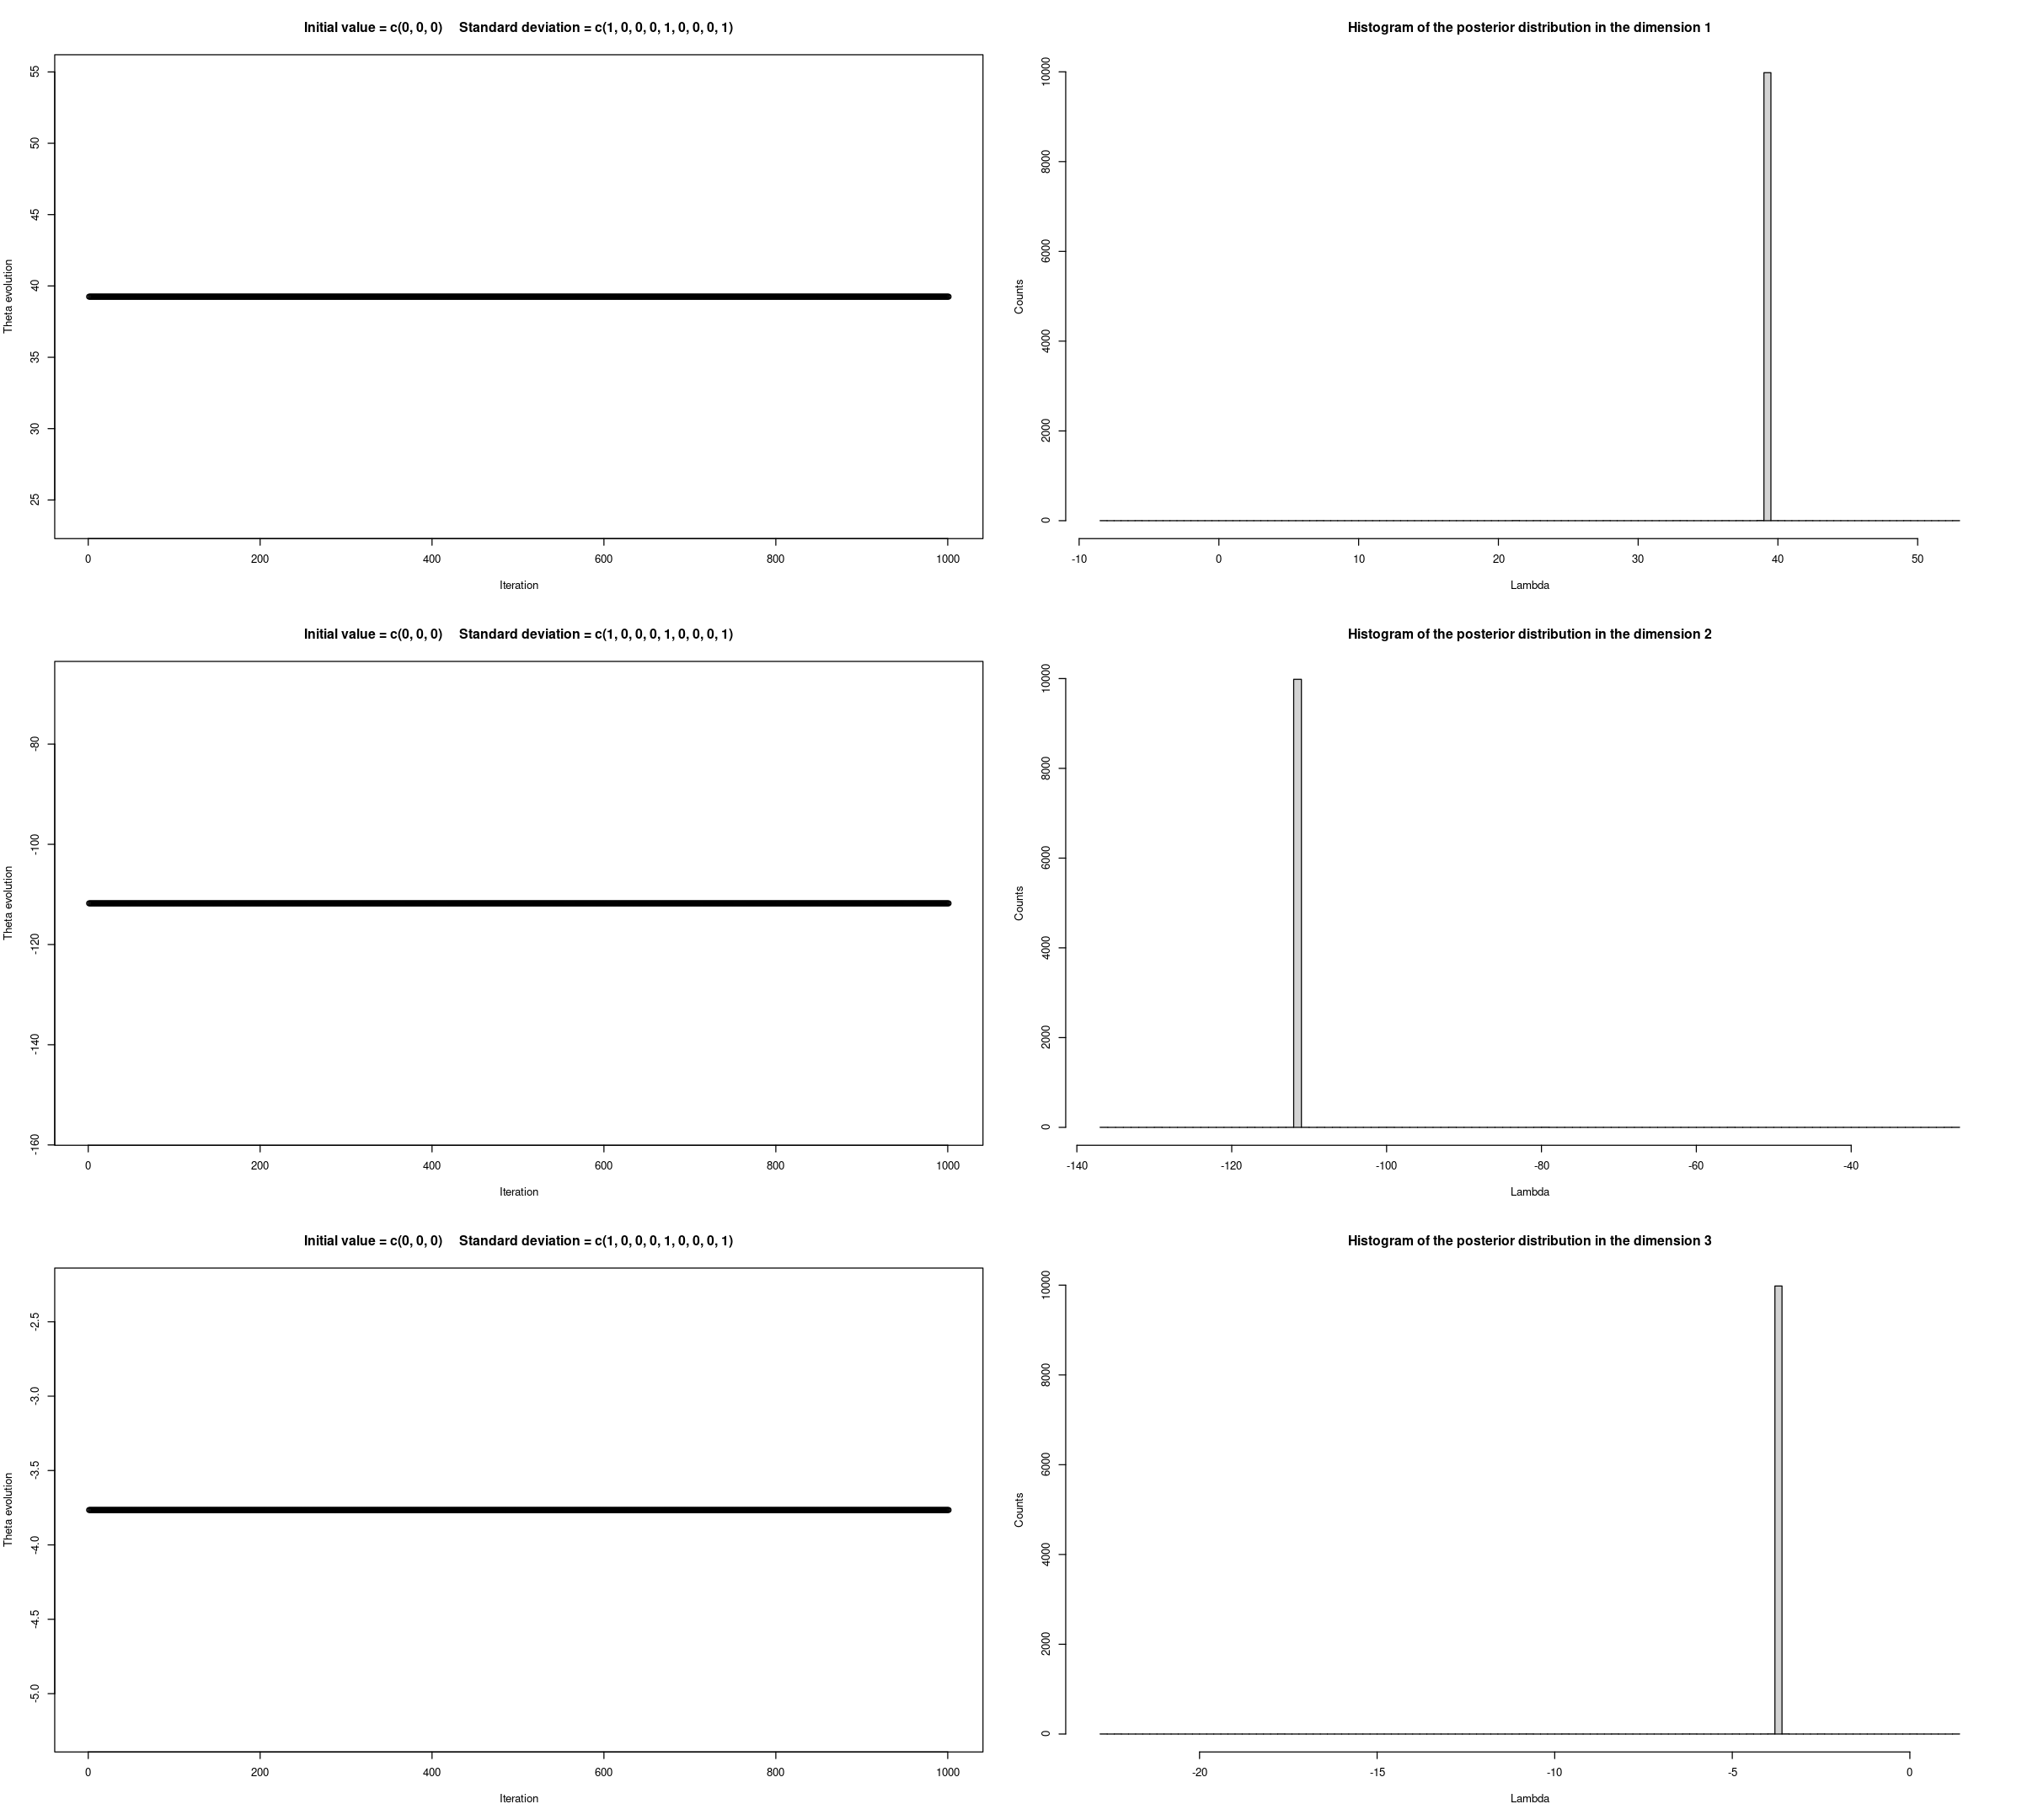

In [7]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 10

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot_g = mcmc_g[seq(1000, 2000, 1), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


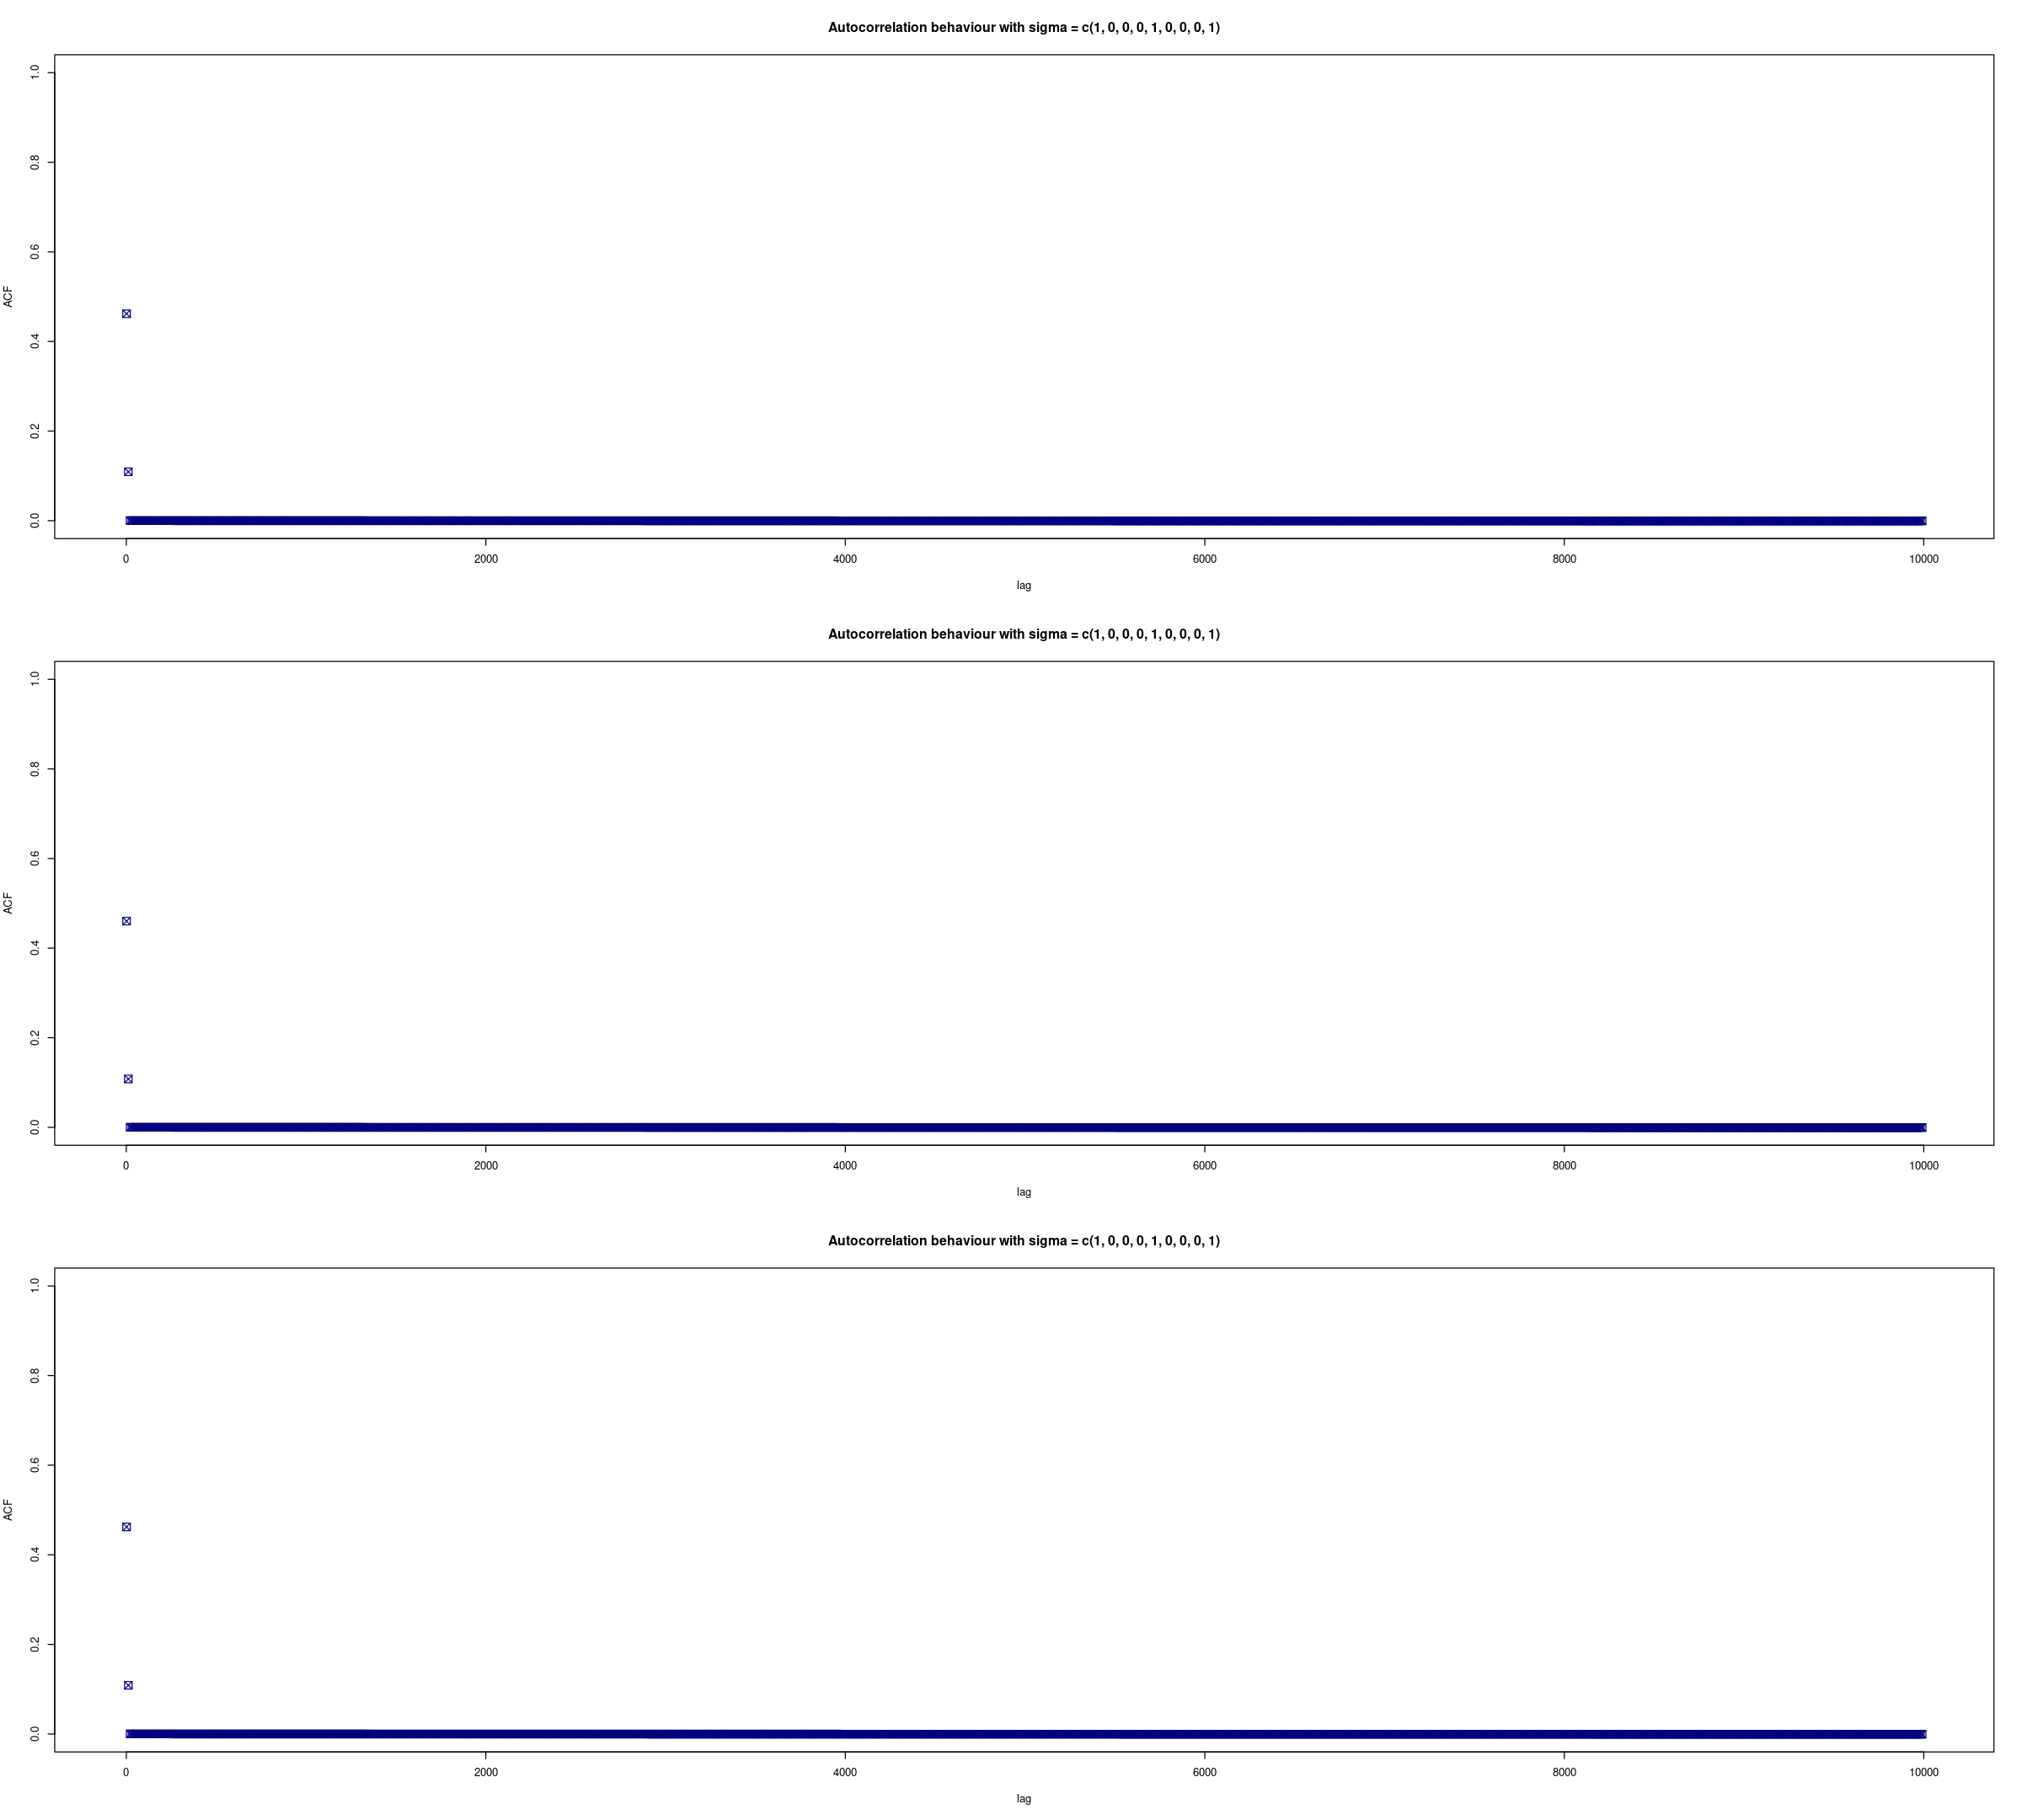

In [8]:
par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,N,step)
    auto_g = autocorr(g_chain, lags=lags)


    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}


# Adaptive Metropolis algorithm (AM + Andrieu + Gibbs)

As explained in the README, here I write the code for the AM with Gibbs sampling


In [9]:
# Now I can change the function to generate the new data in the MCMC

# Then I create the function to extract the random number
generation_s_gibbs = function (x0, cov) {

    # I use the library method to generate the new point
    new_value = rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = FALSE)

    return(new_value)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps_gibbs = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE, t_0 = 1000,
                         gamma_function = gamma_series_exp, halved_step = 1000) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    dimensions = length(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0
    mean = rep(0, length(theta_init))

    # Evolution loop
    for (n in 1:n_samples) {

        guessed_theta = current_theta

        # I then can loop on the dimensions of the distribution to allpy the gibbs sampling
        for (dim in 1:dimensions) {

            # Take a guessed new theta (s in the slides) and evaluate its probability
            guessed_theta[dim] = generation_s_gibbs(current_theta, sigma)[dim]
            guessed_function = func_wanted(guessed_theta)

            # And then update the general conditions
            current_theta = guessed_theta
            current_function = guessed_function    
        }

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

        # Here I evaluate the sampled mean and covariance 
        if (n == t_0) {
            mean = sampled_mean(series = head(samples[,-1], t_0))
            sigma = sampled_covariance(series = head(samples[,-1], t_0), mean = mean)
        } else if (n > t_0) { # and then at every step I update it with the previously declared functions
            old_mean = mean
            mean = update_mean_andrieu(old_mean = mean, new_value = current_theta, step = n,
                                       gamma_function = gamma_function, halved_step = halved_step)
            sigma = update_cov_andrieu(old_cov = sigma, old_mean = old_mean, new_value = current_theta,
                                       step = n, gamma_function = gamma_function, halved_step = halved_step)
        }


    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/(n_samples*dimensions)*100, 5), '%\n')
        cat("Final mean = ", mean, "\n")
        cat("Final covariance matrix = \n")
        print(sigma)
    }

    return(samples)
}


In [10]:
# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}

# The initial parameters are:
init = c(0, 0, 0)
std = diag(1, 3)
N = as.integer(1e4)
burn_in = as.integer(1e3)
N_tot = N + burn_in

# Evaluate then the MCMC
# mcmc_g = random_steps_gibbs(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N_tot, sigma = std, print_accept=TRUE, t_0 = burn_in,
#                       gamma_function = gamma_series_exp, halved_step = 8000) # gamma = exponential
mcmc_g = random_steps_gibbs(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N_tot, sigma = std, print_accept=TRUE, t_0 = burn_in,
                      gamma_function = gamma_series_rec, halved_step = 10000) # gamma = reciprocal

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N_tot, ]


Acceptance rate =  0 %
Final mean =  32.3387 -17.29275 -124.7946 
Final covariance matrix = 
     [,1] [,2] [,3]
[1,]    0    0    0
[2,]    0    0    0
[3,]    0    0    0


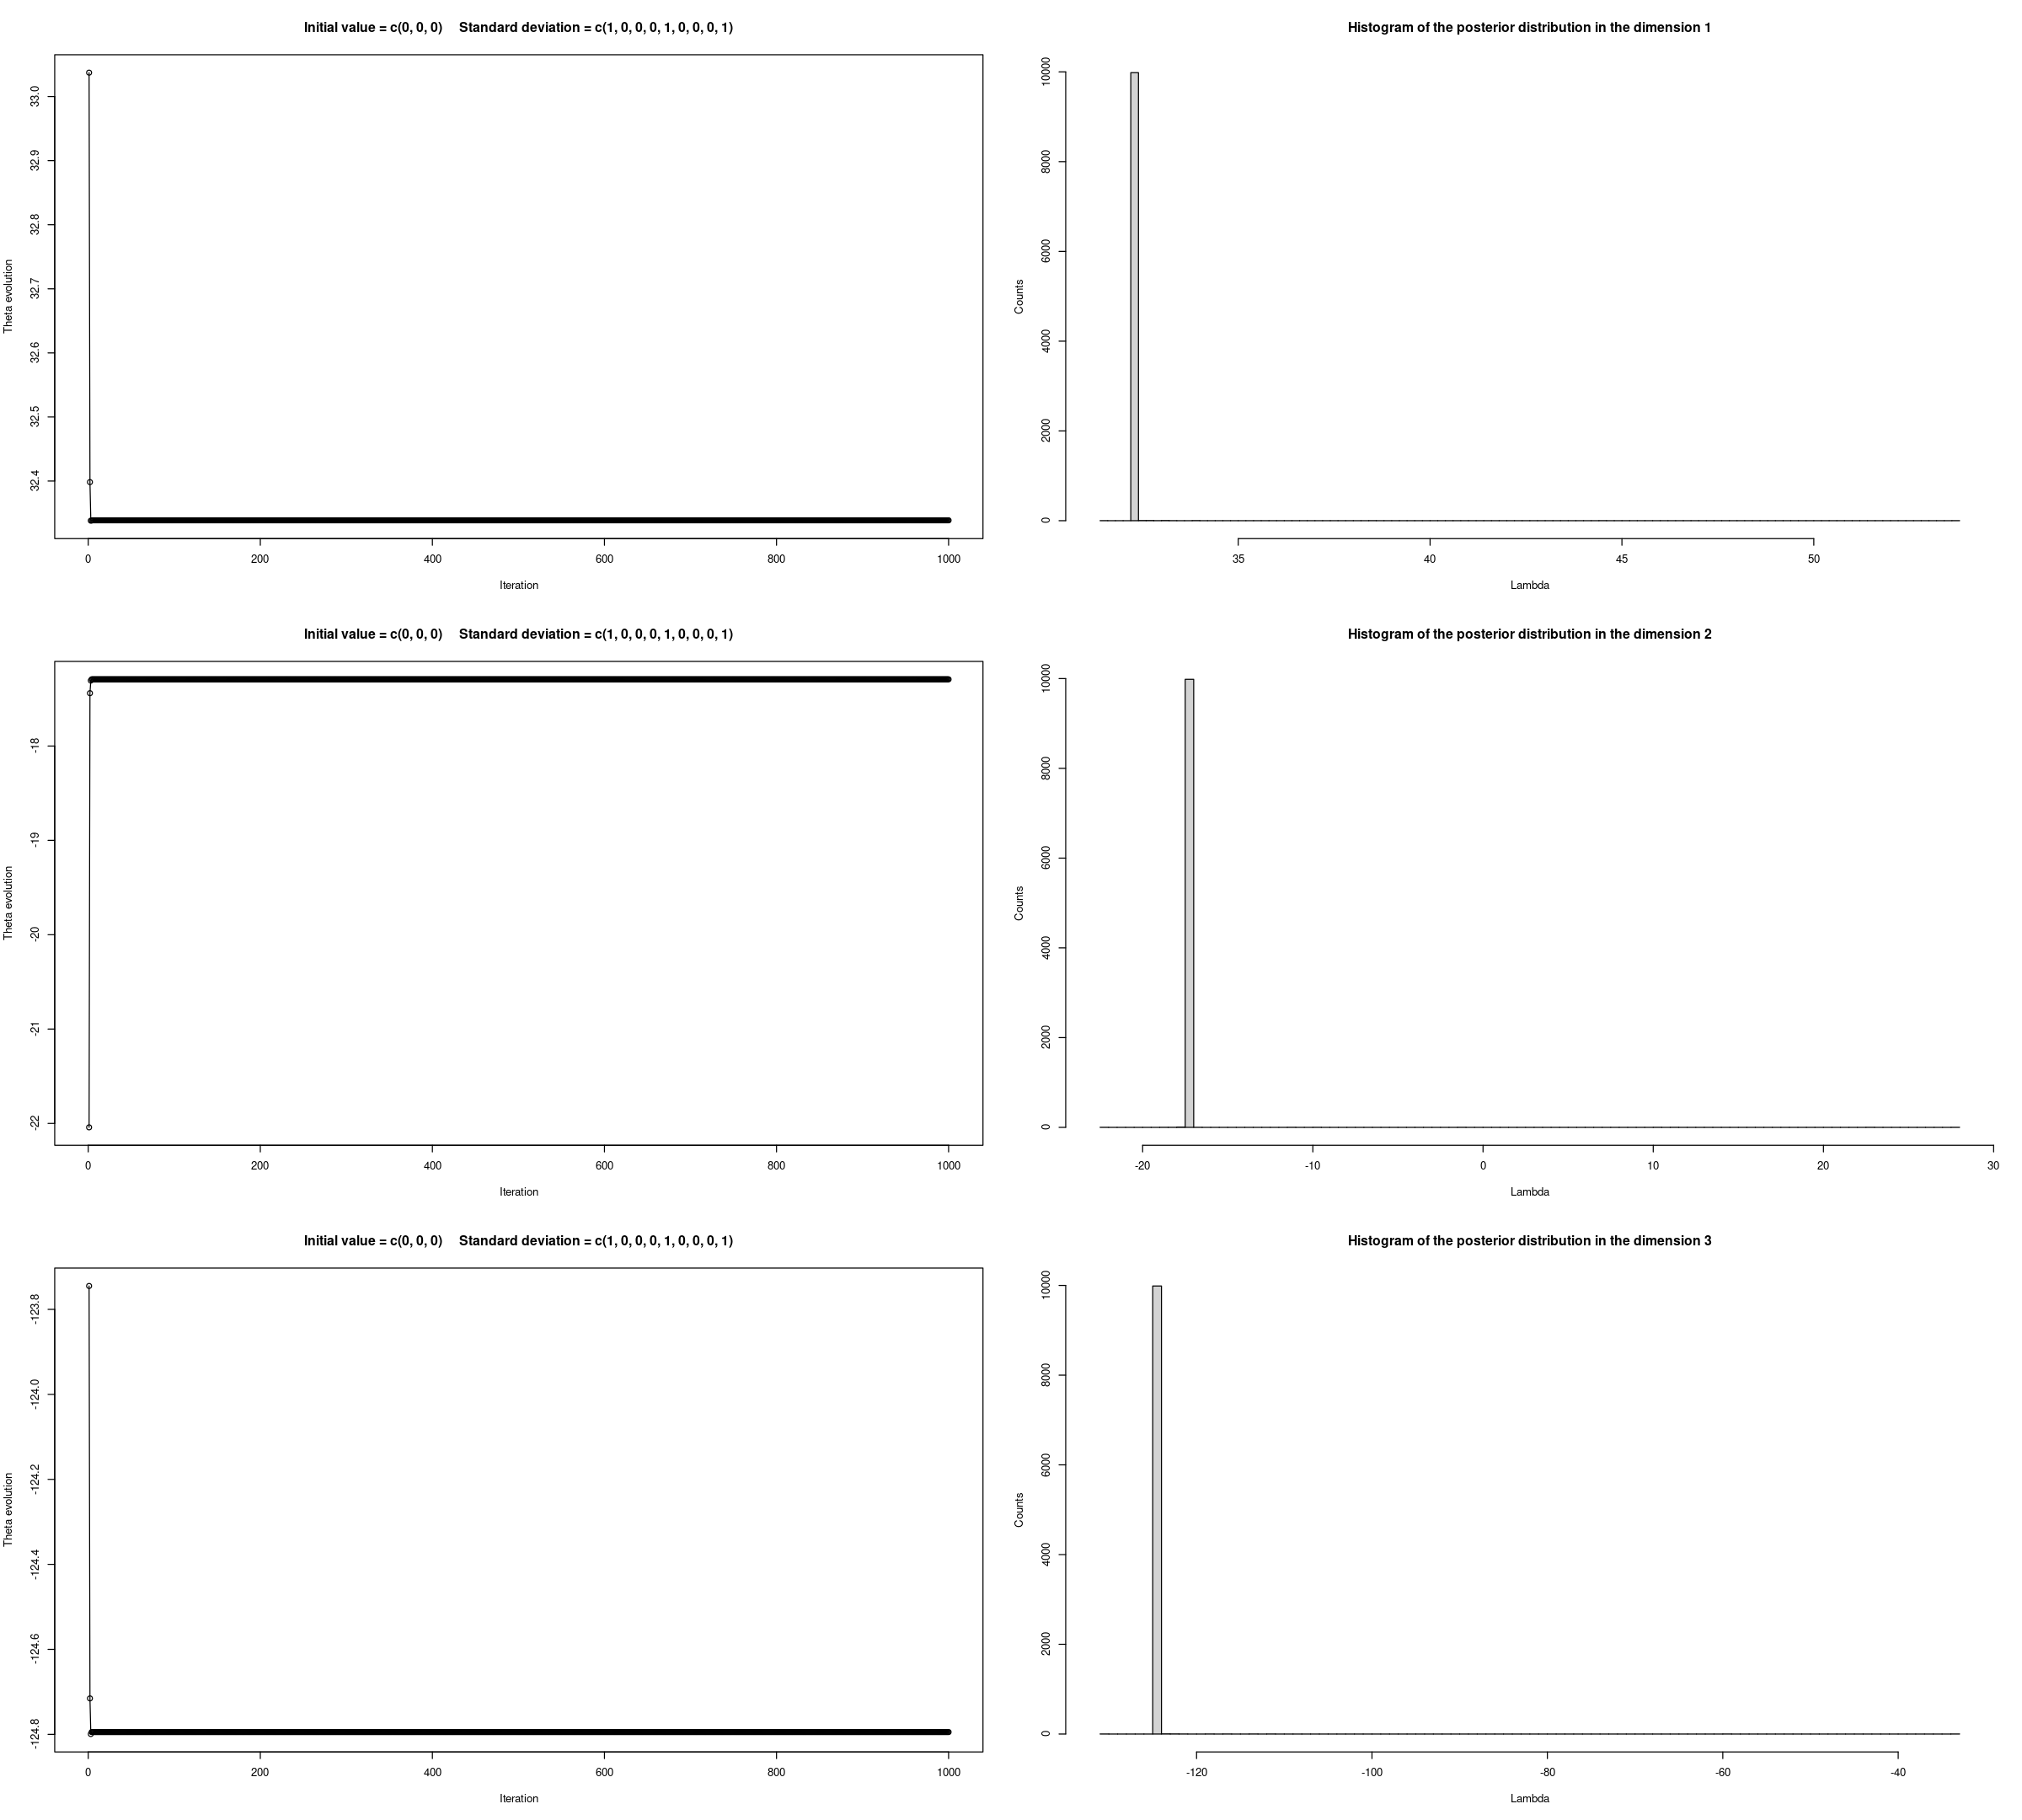

In [11]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 10

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


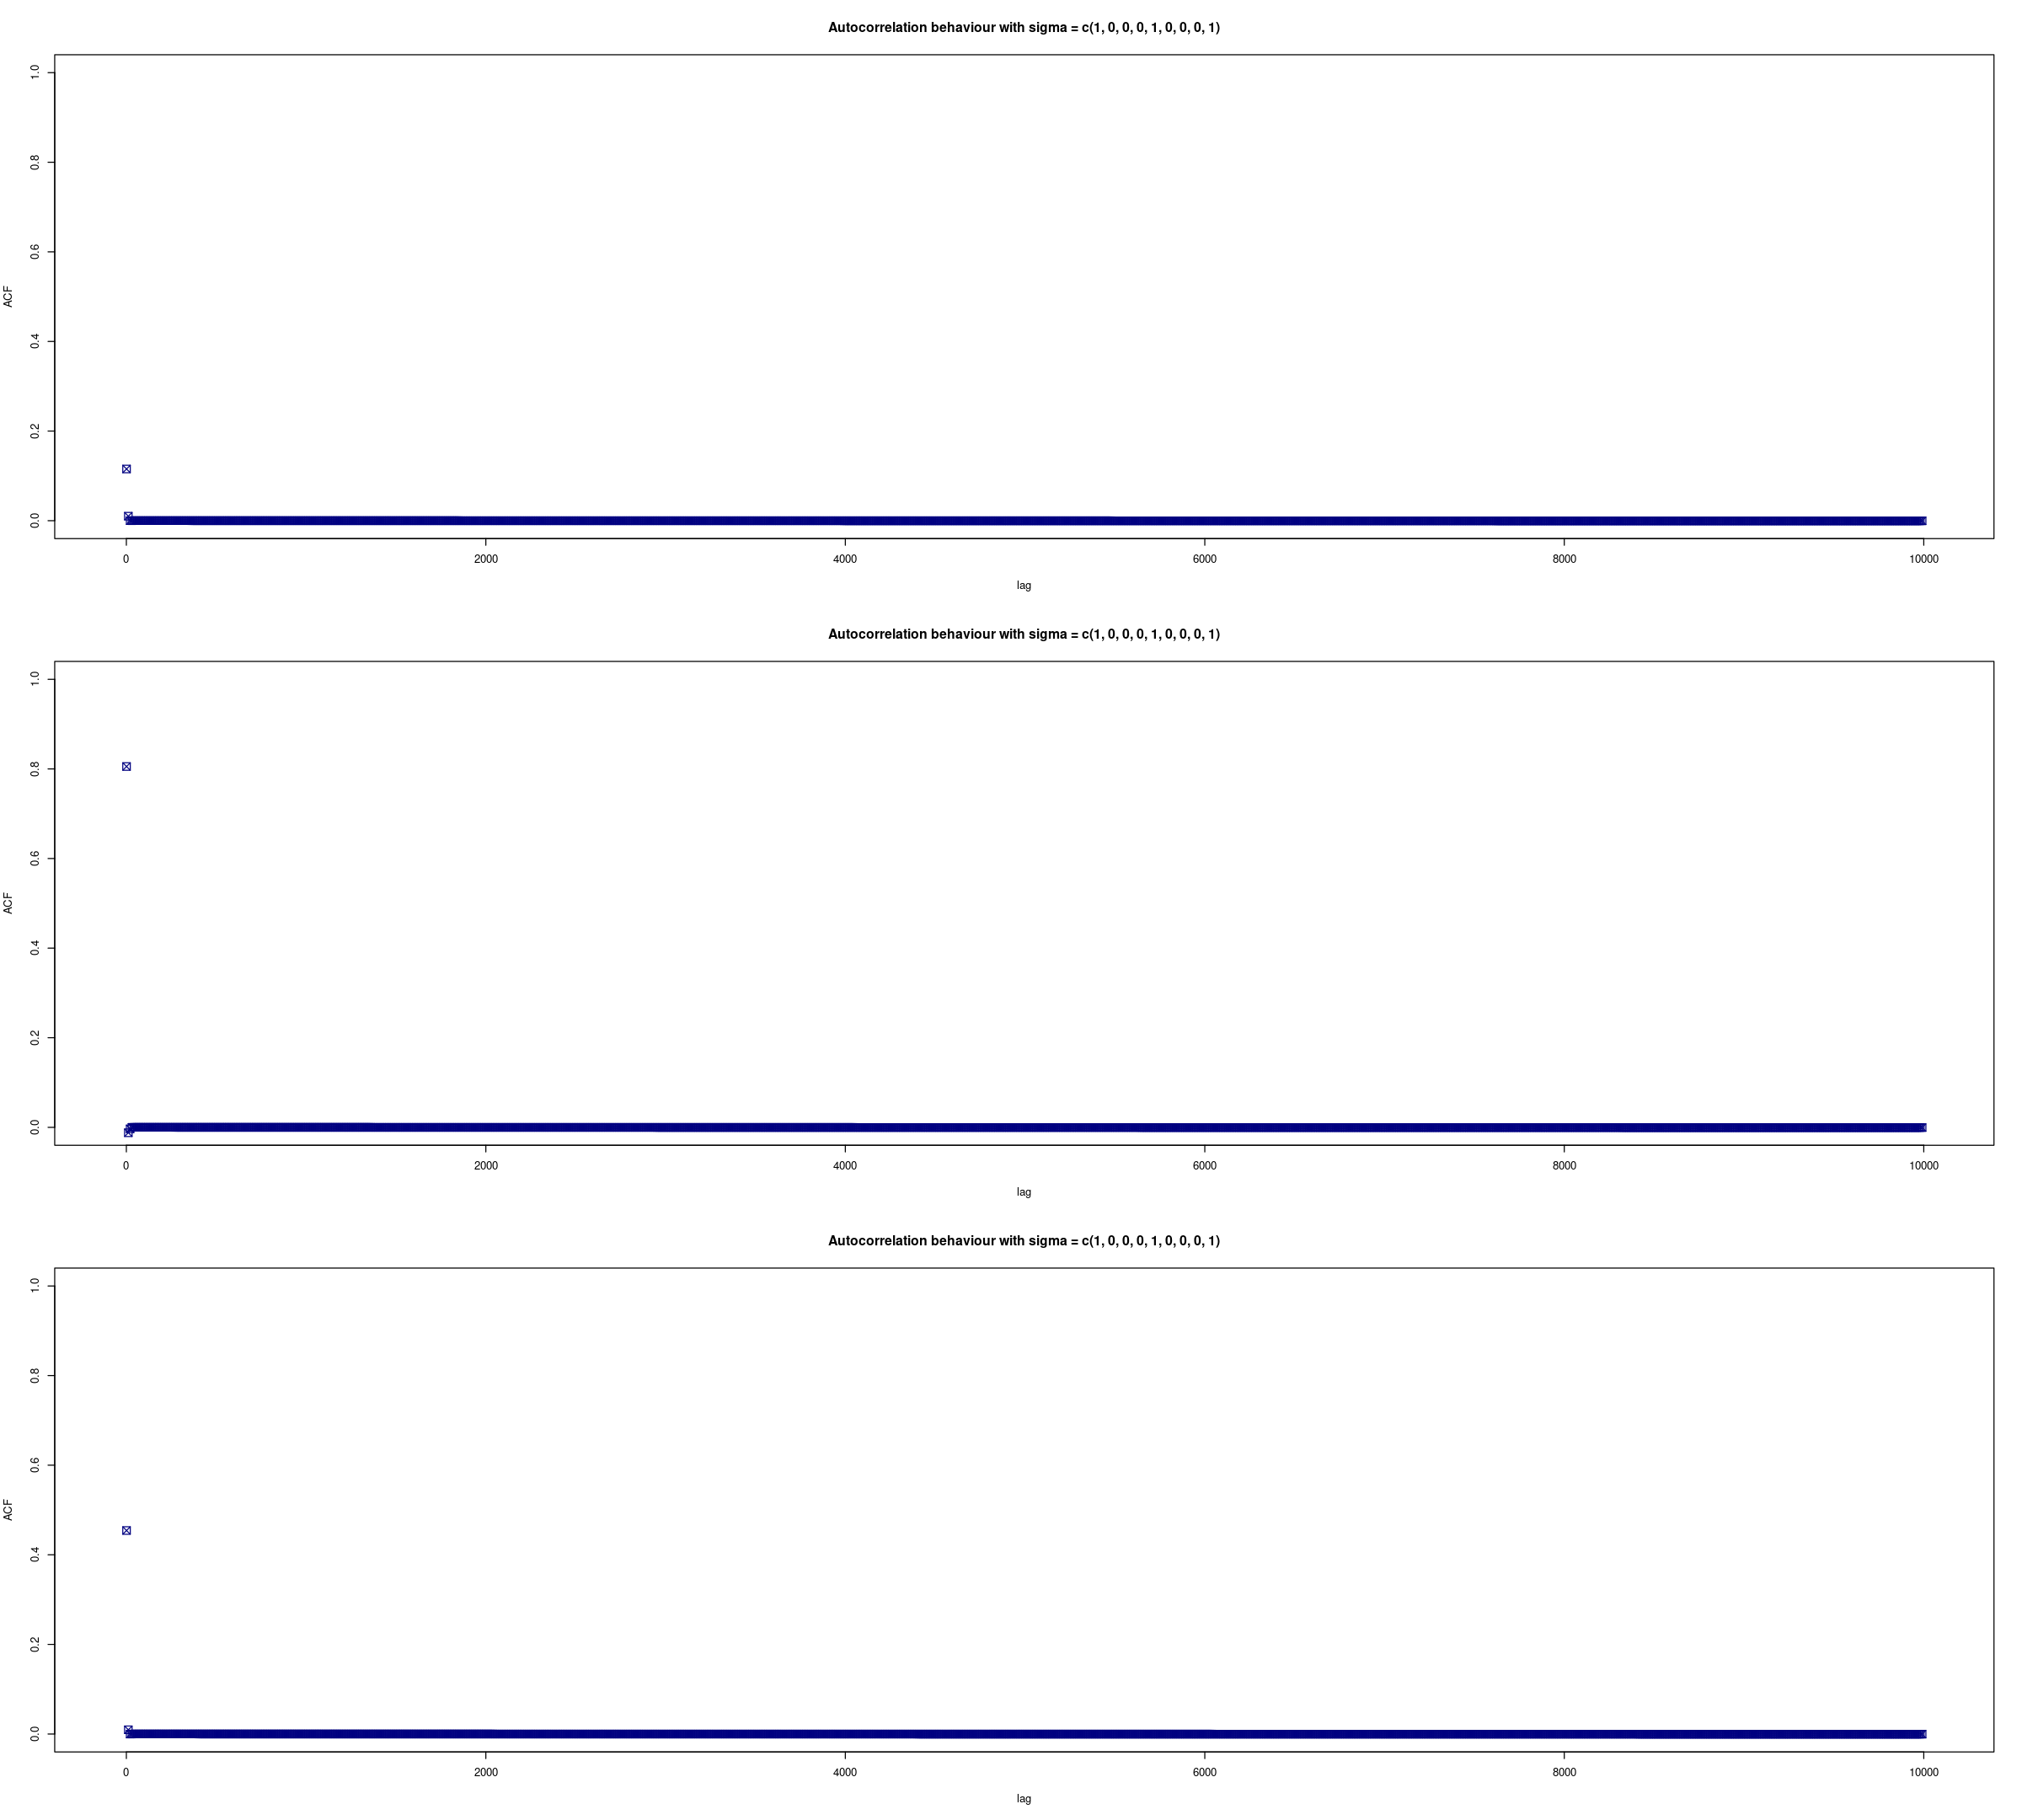

In [12]:
par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,N,step)
    auto_g = autocorr(g_chain, lags=lags)


    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}
